In [1]:
import torch
from torch import nn
from d2l import torch as d2l

class Reshape(nn.Module):
    def forward(self,X):
        return X.view(-1,1,28,28)


net=nn.Sequential(
    Reshape(),
    #这一层卷积之后 输出的是一个6×28×28的张量
    nn.Conv2d(1,6,kernel_size=(5,5),padding=2),nn.Sigmoid(),
    #这一层池化之后，输出的是一个6×14×14的张量
    nn.AvgPool2d(kernel_size=(2,2),stride=(2,2)),
    #这一层卷积之后，输出的是一个16×10×10的张量
    nn.Conv2d(6,16,kernel_size=(5,5)),nn.Sigmoid(),
    #这一层池化之后输出的是一个16×5×5的张量
    nn.AvgPool2d(kernel_size=(2,2),stride=(2,2)),
    nn.Flatten(),
    nn.Linear(16*5*5,120),nn.Sigmoid(),
    nn.Linear(120,84),nn.Sigmoid(),
    #我们对原始模型做了一点小改动，去掉了最后一层的高斯激活。
    # 除此之外，这个网络与最初的 LeNet-5 一致。
    nn.Linear(84,10)
)

下面，我们将一个大小为  28×28  的单通道（黑白）图像通过 LeNet。 通过在每一层打印输出的形状，我们可以检查模型，以确保其操作与我们期望的一致

In [2]:
X=torch.rand(size=(1,1,28,28),dtype=torch.float32)

for layer in net:
    X=layer(X)
    print(layer.__class__.__name__,'output shape:\t',X.shape)

Reshape output shape:	 torch.Size([1, 1, 28, 28])
Conv2d output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
Sigmoid output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


In [3]:
batch_size=256
train_iter,test_iter =d2l.load_data_fashion_mnist(batch_size=batch_size)

C:\Users\Weirdo\CodingEnvitonmentAndIDE\envs\DeepLearning\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [8]:
def evaluate_accuracy_gpu(net,data_iter,device=None):
    if isinstance(net,nn.Module):
        net.eval()
        if not device:
            device=next(iter(net.parameters())).device
    #metric记录两个数据一个是正确预测的数据量，一个是总的数据量
    metric=d2l.Accumulator(2)

    for X,y in data_iter:
        if isinstance(X,list):
            X=[x.to(device) for x in X]
        else:
            X=X.to(device)
        y=y.to(device)

        metric.add(d2l.accuracy(net(X),y),y.numel())
        return metric[0]/metric[1]

In [10]:
def train_ch6(net,train_iter,test_iter,num_epochs,lr,device):
    #这个函数用来初始化参数
    def init_weight(m):
        if type(m)==nn.Linear or type(m)==nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weight)

    print('training on ',device)
    net.to(device)
    optimizer=torch.optim.SGD(net.parameters(),lr=lr)
    loss=nn.CrossEntropyLoss()
    animator=d2l.Animator(xlabel='epoch',xlim=[1,num_epochs],
                            legend=['train loss','train_acc','test acc'])
    timer,num_batches=d2l.Timer(),len(train_iter)

    #开始训练
    for epoch in range(num_epochs):
        #记录训练损失之和，训练准确率之和，范例数
        metric=d2l.Accumulator(3)
        net.train()

        for i,(X,y) in enumerate(train_iter):
            #这一块是对模型进行训练并且记录训练所用的时间
            timer.start()
            optimizer.zero_grad()
            X,y=X.to(device),y.to(device)
            y_hat=net(X)
            l=loss(y_hat,y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l*X.shape[0],d2l.accuracy(y_hat,y),X.shape[0])
            timer.stop()
            print(f'{i}batch 训练完毕')
            #这一块是对训练过程的图像的可视化，即绘制曲线图的过程
            train_l=metric[0]/metric[2]
            train_acc=metric[1]/metric[2]
            #这里的if后的条件是指只取5个点来画图，与上面的for结合后就是每个周期只取5个点画图
            if (i+1)%(num_batches//5)==0 or i==num_batches-1:
                animator.add(epoch+(i+1)/num_batches,(train_l,train_acc,None))
            test_acc=evaluate_accuracy_gpu(net,test_iter)
            #绘制test_acc的线
            animator.add(epoch+1,(None,None,test_acc))
            print(f'loss:{train_l:.3f},train_acc:{train_acc:.3f},test_acc:{test_acc:.3f}')
            print(f'epoch {epoch+1}  {metric[2]*num_epochs/timer.sum()} examples/sec on {str(device)}')



loss:0.463,train_acc:0.827,test_acc:0.852
epoch 10  12238.066358765087 examples/sec on cpu


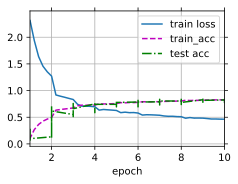

In [11]:
lr,num_epochs=0.9,10
train_ch6(net,train_iter,test_iter,num_epochs,lr,d2l.try_gpu())